<a href="https://colab.research.google.com/github/BhanuCheitanya/DeepLearning/blob/main/train_lstm_mitd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wfdb

In [2]:
#import matplotlib with pdf as backend
import matplotlib as plt
#matplotlib.use('PDF')
from pylab import *
#from matplotlib.backends.backend_pdf import PdfPages

import wfdb 
import os
import numpy as np
import math
import sys
import scipy.stats as st
from sklearn.preprocessing import scale
import glob, os
from os.path import basename
from functools import partial, update_wrapper
from tensorflow import keras
from tensorflow.keras import regularizers
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,Bidirectional, GRU #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense)
from tensorflow.keras import backend as K
from keras.metrics import categorical_accuracy


In [11]:

np.random.seed(42)


def get_ecg_data_nl(datfile):
	## convert .dat/q1c to numpy arrays
	recordname=os.path.basename(datfile).split(".dat")[0]
	recordpath=os.path.dirname(datfile)
	cwd=os.getcwd()
	os.chdir(recordpath) ## somehow it only works if you chdir. 
	record = wfdb.rdsamp(recordname)
	Vctrecord=np.transpose(record.p_signals)
	Vctrecord=np.transpose(Vctrecord)
	return Vctrecord

# functions
def get_ecg_data(datfile): 
    ## convert .dat/q1c to numpy arrays
    recordname=os.path.basename(datfile).split(".dat")[0]
    recordpath=os.path.dirname(datfile)
    cwd=os.getcwd()
    os.chdir(recordpath) ## somehow it only works if you chdir. 

    annotator='atr'
    annotation = wfdb.rdann(recordname, extension=annotator, sampfrom=0,sampto = None)
    record = wfdb.rdrecord(recordname, sampfrom=0,sampto = None) #wfdb.showanncodes()

    Vctrecord=np.transpose(record.p_signal)
    VctAnnotationHot=np.zeros( (2,len(Vctrecord[1])), dtype=np.int)
    VctAnnotationHot[1] = 1;
    
    #print("ecg, 2 lead of shape" , Vctrecord.shape) 
    #print("VctAnnotationHot of shape" , VctAnnotationHot.shape) 
    #print('plotting extracted signal with annotation')
    #wfdb.plotrec(record, annotation=annotation2, title='Record 100 from MIT-BIH Arrhythmia Database', timeunits = 'seconds')

    VctAnnotations=list(zip(annotation.sample,annotation.symbol)) ## zip coordinates + annotations (N),(t) etc)
    #print(VctAnnotations)
    for i in range(len(VctAnnotations)):
        if( VctAnnotations[i][1] == 'N' or 
            VctAnnotations[i][1] == 'L' or  
            VctAnnotations[i][1] == 'R' or 
           VctAnnotations[i][1] == 'B' or 
           VctAnnotations[i][1] == 'A' or
           VctAnnotations[i][1] == 'a' or 
           VctAnnotations[i][1] == 'J' or 
           VctAnnotations[i][1] == 'S' or 
           VctAnnotations[i][1] == 'V' or  
           VctAnnotations[i][1] == 'r' or  
           VctAnnotations[i][1] == 'F' or 
           VctAnnotations[i][1] == 'e' or 
           VctAnnotations[i][1] == 'j' or
           VctAnnotations[i][1] == 'n' or 
           VctAnnotations[i][1] == 'E' or 
           VctAnnotations[i][1] == '/' or 
           VctAnnotations[i][1] == 'f' or
           VctAnnotations[i][1] == 'Q' or  
           VctAnnotations[i][1] == '?'):
            VctAnnotationHot[0][VctAnnotations[i][0]] = 1;  
            VctAnnotationHot[1][VctAnnotations[i][0]] = 0;  
    VctAnnotationHot=np.transpose(VctAnnotationHot)
    Vctrecord=np.transpose(Vctrecord) # transpose to (timesteps,feat)

    os.chdir(cwd)
    return Vctrecord, VctAnnotationHot



def splitseq(x,n,o):
	n = int(n)
	o = int(o)
	#split seq; should be optimized so that remove_seq_gaps is not needed. 
	upper= int(math.ceil( x.shape[0] / n) *n)
	print("splitting on",n,"with overlap of ",o,	"total datapoints:",x.shape[0],"; upper:",upper)
	for i in range(0,upper,n):
		#print(i)
		if i==0:
			padded=np.zeros( ( o+n+o,x.shape[1])   ) ## pad with 0's on init
			padded[o:,:x.shape[1]] = x[i:i+n+o,:]
			xpart=padded
		else:
			xpart=x[i-o:i+n+o,:]
		if xpart.shape[0]<i:

			padded=np.zeros( (o+n+o,xpart.shape[1])  ) ## pad with 0's on end of seq
			padded[:xpart.shape[0],:xpart.shape[1]] = xpart
			xpart=padded

		xpart=np.expand_dims(xpart,0)## add one dimension; so that you get shape (samples,timesteps,features)
		try:
			xx=np.vstack(  (xx,xpart) )
		except UnboundLocalError: ## on init
			xx=xpart
	print("output: ",xx.shape)
	return(xx)

def remove_seq_gaps(x,y):
	#remove parts that are not annotated <- not ideal, but quickest for now.
	window=150
	c=0
	cutout=[]
	include=[]
	print("filterering.")
	print("before shape x,y",x.shape,y.shape)
	for i in range(y.shape[0]):
		
		c=c+1
		if c<window :
			include.append(i)
		if sum(y[i,0:5])>0:
			c=0 
		if c >= window:
			#print ('filtering')
			pass
	x,y=x[include,:],y[include,:]
	print(" after shape x,y",x.shape,y.shape)
	return(x,y)


def normalize_new(x):
    for i in range(x.shape[0]):
        x[i] = scale( x[i], axis=0, with_mean=True, with_std=True, copy=True )
    return x

def normalizesignal(x):
	x=st.zscore(x, ddof=0)
	return x
def normalizesignal_array(x):
	for i in range(x.shape[0]):
		x[i]=st.zscore(x[i], axis=0, ddof=0)
	return x

def plotecg(x,y,begin,end):
	#helper to plot ecg
	plt.figure(1,figsize=(11.69,8.27))
	plt.subplot(211)
	plt.plot(x[begin:end,0])
	plt.subplot(211)
	plt.plot(y[begin:end,0])
	plt.subplot(211)
	plt.plot(y[begin:end,1])
	plt.subplot(211)
	plt.plot(y[begin:end,2])
	plt.subplot(211)
	plt.plot(y[begin:end,3])
	plt.subplot(211)
	plt.plot(y[begin:end,4])
	plt.subplot(211)
	plt.plot(y[begin:end,5])

	plt.subplot(212)
	plt.plot(x[begin:end,1])
	plt.show()

def plotecg_validation(x,y_true,y_pred,begin,end):
	#helper to plot ecg
	plt.figure(1,figsize=(11.69,8.27))
	plt.subplot(211)
	plt.plot(x[begin:end,0])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,0])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,1])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,2])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,3])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,4])
	plt.subplot(211)
	plt.plot(y_pred[begin:end,5])

	plt.subplot(212)
	plt.plot(x[begin:end,1])
	plt.subplot(212)
	plt.plot(y_true[begin:end,0])
	plt.subplot(212)
	plt.plot(y_true[begin:end,1])
	plt.subplot(212)
	plt.plot(y_true[begin:end,2])
	plt.subplot(212)
	plt.plot(y_true[begin:end,3])
	plt.subplot(212)
	plt.plot(y_true[begin:end,4])
	plt.subplot(212)
	plt.plot(y_true[begin:end,5])

    
def LoaddDatFiles(datfiles):  
    for datfile in datfiles:
        print(datfile)
        if basename(datfile).split(".",1)[0] in exclude:
            continue
        qf=os.path.splitext(datfile)[0]+'.atr'
        if os.path.isfile(qf):
            #print("yes",qf,datfile)
            x,y=get_ecg_data(datfile)

            x,y=splitseq(x,1000,0),splitseq(y,1000,0) ## create equal sized numpy arrays of n size and overlap of o 

            x = normalize_new(x)
            ## todo; add noise, shuffle leads etc. ?
            try: ## concat
                xx=np.vstack(  (xx,x) )
                yy=np.vstack(  (yy,y) )
            except NameError: ## if xx does not exist yet (on init)
                xx = x
                yy = y
    return(xx,yy)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_session(gpu_fraction=0.8):
	#allocate % of gpu memory.
	num_threads = os.environ.get('OMP_NUM_THREADS')
	gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
	if num_threads:
		return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
	else:
		return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from keras import backend as K

import numpy as np
from keras.activations import softmax
from tensorflow.keras.metrics import categorical_crossentropy

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def build_model_gru():
    #data_dim = X_data.shape[2]
    #timesteps = X_data.shape[1]
    model = Sequential()
    model.add(BatchNormalization(input_shape=(seqlength, features)))  
    model.add(GRU(output_dim=50,init ='glorot_normal',
         return_sequences=True, W_regularizer=regularizers.l2(0.00),U_regularizer=regularizers.l1(0.01),dropout_W =0.2 ))
    model.add(GRU(output_dim=50,init ='glorot_normal',
        return_sequences=True,W_regularizer=regularizers.l2(0.00),U_regularizer=regularizers.l1(0.01),dropout_W =0.2))
    model.add(GRU(50,init ='glorot_normal',return_sequences=False,dropout_W =0.01, W_regularizer=regularizers.l2(0.00),U_regularizer=regularizers.l1(0.01)))
    model.add(Dense(dimout, init='glorot_normal'))
    model.add(Activation('softmax'))

    #weights = np.ones((dimout,))
    weights = np.array([0.8, 500.0])
    model.compile(loss=weighted_categorical_crossentropy(weights),optimizer='Adam')
    return model

def getmodel_simple():
    # create model
    model = Sequential()
    model.add(Dense(1000,W_regularizer=regularizers.l2(l=0.01), input_shape=(seqlength, features)))
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(dimout, activation='softmax'))
    # Compile model
    weights = np.array([128., 0.1])
    adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)
    model.compile(loss=weighted_categorical_crossentropy(weights),optimizer=adam, metrics=['accuracy']) #(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
    return model

def getmodel():
    model = Sequential()
    model.add(Dense(32,W_regularizer=regularizers.l2(l=0.01), input_shape=(seqlength, features)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu',W_regularizer=regularizers.l2(l=0.01)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(dimout, activation='softmax'))
    adam = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    weights = np.array([64.0, 0.1,])
    model.compile(loss=weighted_categorical_crossentropy(weights),optimizer=adam, metrics=['accuracy']) #(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
    print(model.summary())
    return(model)

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


def getmodel_one():
    model = Sequential()
    model.add(Dense(32, input_shape=(seqlength, features)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))#, input_shape=(seqlength, features)) ) ### bidirectional ---><---
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(dimout, activation='sigmoid'))
    #adam = tf.keras.optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    weights = np.array([64.0, 0.1,])
    model.compile(loss=f1_loss, #loss=weighted_categorical_crossentropy(weights),  
                  metrics=['categorical_accuracy', f1_m,precision_m, recall_m]) #(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
    print(model.summary())
    return(model)


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:

## USE CPU otherwise need a lot of memory in the GPU
from keras import backend as KTF
import tensorflow as tf

num_cores = 4
GPU = 0
CPU = 1

if GPU:
    num_GPU = 1
    num_CPU = 6
if CPU:
    num_CPU = 7
    num_GPU = 0

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.compat.v1.Session(config=config)
KTF.set_session(session)

In [6]:
# test 1 that it works the same as categorical_crossentropy with weights of one
# weights = np.ones(2)
# y_true = K.variable(xxt)
# y_pred = K.variable(yyt)
# loss_weighted=weighted_categorical_crossentropy(weights)(y_true,y_pred).eval(session=K.get_session())
# loss=categorical_crossentropy(y_true,y_pred).eval(session=K.get_session())
# np.testing.assert_almost_equal(loss_weighted,loss)
# print('OK test1')
### TESTING CATEGORICAL CROSS ENTROPY WEIGHTED
# test 2 that it works differen't than categorical_crossentropy with weights of less than one
#weights = np.array([0.1,2.5])
#loss_weighted=weighted_categorical_crossentropy(weights)(y_true,y_pred).eval(session=K.get_session())
#loss=categorical_crossentropy(y_true,y_pred).eval(session=K.get_session())
#np.testing.assert_array_less(loss_weighted,loss)
#print('OK test2')


In [ ]:
#model =  build_model_gru() # getmodel() 
#model = getmodel()

In [20]:
## MITDB
import os
import wfdb

qtdbpath="/content/sample_data/xyz/"#sys.argv[1] ## first argument = qtdb database from physionet. 

# load data
datfiles=glob.glob(qtdbpath+"*.dat")
datfiles

['/content/sample_data/xyz/213.dat',
 '/content/sample_data/xyz/233.dat',
 '/content/sample_data/xyz/223.dat',
 '/content/sample_data/xyz/107.dat',
 '/content/sample_data/xyz/209.dat',
 '/content/sample_data/xyz/207.dat',
 '/content/sample_data/xyz/102.dat',
 '/content/sample_data/xyz/122.dat',
 '/content/sample_data/xyz/103.dat',
 '/content/sample_data/xyz/208.dat',
 '/content/sample_data/xyz/108.dat',
 '/content/sample_data/xyz/104.dat',
 '/content/sample_data/xyz/217.dat',
 '/content/sample_data/xyz/200.dat',
 '/content/sample_data/xyz/232.dat',
 '/content/sample_data/xyz/112.dat',
 '/content/sample_data/xyz/106.dat',
 '/content/sample_data/xyz/113.dat',
 '/content/sample_data/xyz/117.dat',
 '/content/sample_data/xyz/230.dat',
 '/content/sample_data/xyz/212.dat',
 '/content/sample_data/xyz/114.dat',
 '/content/sample_data/xyz/221.dat',
 '/content/sample_data/xyz/228.dat',
 '/content/sample_data/xyz/231.dat',
 '/content/sample_data/xyz/201.dat',
 '/content/sample_data/xyz/118.dat',
 

In [21]:
# load data
perct=0.81 #percentage training
percv=0.19 #percentage validation
exclude = set()
#exclude.update(["234"])# no P annotated:
datfiles=glob.glob(qtdbpath+"*.dat")

In [22]:
for datfile in datfiles[0:1]:
    print(datfile)
    if basename(datfile).split(".",1)[0] in exclude:
        continue
    qf=os.path.splitext(datfile)[0]+'.atr'
    if os.path.isfile(qf):
        #print("yes",qf,datfile)
        x,y=get_ecg_data(datfile)

        x,y=splitseq(x,1000,0),splitseq(y,1000,0) ## create equal sized numpy arrays of n size and overlap of o 

        x = normalize_new(x)
        ## todo; add noise, shuffle leads etc. ?
        try: ## concat
            xx=np.vstack(  (xx,x) )
            yy=np.vstack(  (yy,y) )
        except NameError: ## if xx does not exist yet (on init)
            xx = x
            yy = y

/content/sample_data/xyz/213.dat
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)


In [23]:
x,y=get_ecg_data(datfile)

In [ ]:
x

array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]])

In [24]:
inp_size = 1000;
xs,ys=splitseq(x,inp_size,0),splitseq(y,inp_size,0)
xs.shape

splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)


(650, 1000, 2)

In [25]:
ys.shape

(650, 1000, 2)

In [26]:
pip install mpld3

     |████████████████████████████████| 201 kB 5.1 MB/s 


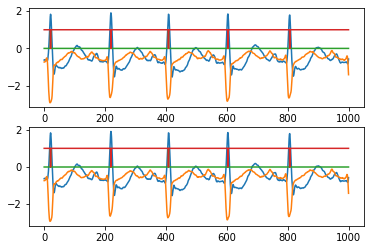

In [27]:
import mpld3
mpld3.enable_notebook()
batch = 3;
subplot(2,1,1)
plot(x[batch*inp_size:(batch+1)*inp_size,:])
plot(y[batch*inp_size:(batch+1)*inp_size,:])
subplot(2,1,2)
plot(xs[batch,:,:])
plot(ys[batch,:,:])

In [28]:
xxt,yyt=LoaddDatFiles(datfiles[ :int(round(len(datfiles)*perct)) ]) # training data. 
xxt,yyt=unison_shuffled_copies(xxt,yyt) ### shuffle
xxv,yyv=LoaddDatFiles(datfiles[ -int(round(len(datfiles)*percv)): ] ) ## validation data.
seqlength=xxt.shape[1]
features=1#xxt.shape[2]
dimout=yyt.shape[2]
print("xxv/validation shape: {}, Seqlength: {}, Features: {}".format(xxv.shape[0],seqlength,features))

/content/sample_data/xyz/213.dat
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
/content/sample_data/xyz/233.dat
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
/content/sample_data/xyz/223.dat
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
/content/sample_data/xyz/107.dat
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
splitting on 1000 with overlap of  0 total datapoints: 650000 ; upper: 650000
output:  (650, 1000, 2)
/content/sample_data/xyz/209.dat
splitting on 1000 w

In [29]:
dimout

2

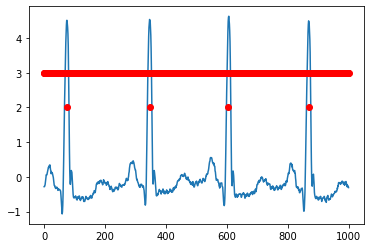

In [30]:
i = 150
plot(xxt[i,:,0])
plot(yyt[i,:,1]+2, 'ro')

In [31]:
yyt.shape

(24700, 1000, 2)

In [32]:
# USE BOTH CHANNELS
pcha=xxt[:,:,1]; 
pchb=xxt[:,:,0];
#xxv[:,:,1] = xxv[:,:,0];
yyt.shape[0]*2

49400

In [33]:
all_x = np.vstack([pcha, pchb])
all_x = np.expand_dims(all_x,2)
all_lab = np.vstack([yyt, yyt])
print(all_lab.shape)
print(all_x.shape)

(49400, 1000, 2)
(49400, 1000, 1)


In [34]:
# call keras/tensorflow and build lstm model 
#index_ = np.linspace(0, all_x.shape[0]-1, all_x.shape[0] ).astype(int);
#shuffle(index_)

# TRAIN
KTF.set_session(session)
NUM = all_x.shape[0]
with tf.compat.v1.Session(): #switch to /cpu:0 to use cpu 
    #if not os.path.isfile('model_mitd_binary_noover.h5'):
    model = getmodel_one()#getmodel() #build_model_gru() 
    #model = getmodel_simple();
    for this_eps in range(10):
        model.fit(all_x[0:NUM,:,:], all_lab[0:NUM,:,:], batch_size=100, epochs=1, verbose=1) # train the model
        model.save('model_mitd_binary_noover_eps_f1loss_'+str(this_eps)+'_.h5')
        model.save_weights('model_weights_mitd_binary_noover_eps_f1loss_'+str(this_eps)+'_.h5')

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000, 32)          64        
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 128)        49664     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 1000, 128)        512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1000, 32)          4128      
                                                  

In [35]:
#load weights because of the custom metrics 
from keras.models import load_model

with tf.device('/cpu:0'): #switch to /cpu:0 to use cpu 
   
    model = getmodel_one()
    model.load_weights('model_weights_mitd_binary_noover_eps_f1loss_0_.h5')


    #model = load_model('model_mitd_binary_noover_eps_mitdb_0_.h5', 
    #                   custom_objects=dependencies)    
    loss, cat_acc , f1_score, precision, recall = model.evaluate(all_x[0:NUM,:,:], all_lab[0:NUM,:,:], batch_size=100, verbose=1)
    print('f1_score: {} , CatAcc: {}, Precision: {}, Recall: {}'.format(f1_score, cat_acc,  precision, recall))

    # predict
    yy_predicted = model.predict(all_x[0:NUM,:,:]) 

    # maximize probabilities of prediction.
    for i in range(all_lab[0:NUM,:,:].shape[0]): 
        b = np.zeros_like(yy_predicted[i,:,:])
        b[np.arange(len(yy_predicted[i,:,:])), yy_predicted[i,:,:].argmax(1)] = 1
        yy_predicted[i,:,:] = b

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1000, 32)          64        
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 128)        49664     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1000, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 1000, 128)        512       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1000, 32)          4128      
                                                                 
 dropout_3 (Dropout)         (None, 1000, 32)         

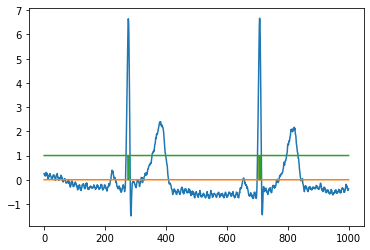

In [36]:

# PLOT
i = 1
plt.plot(all_x[i,:,:])
plt.plot(yy_predicted[i,:,:])

In [37]:
yy_predicted = model.predict(all_x[0:2000,:,:])

In [38]:
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

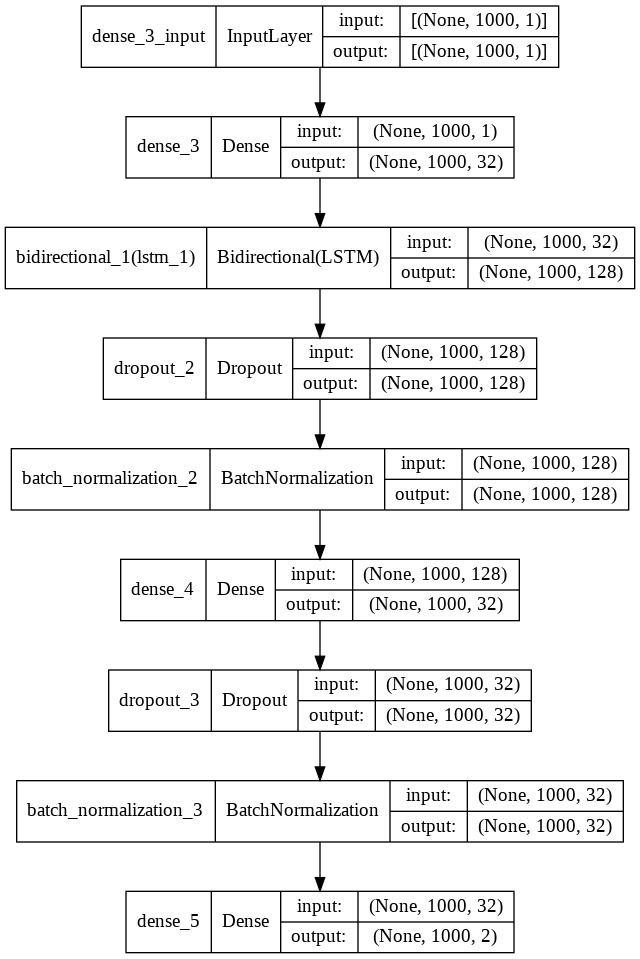

In [39]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
yyt.shape

(24700, 1000, 2)

In [41]:
yy_predicted

array([[[3.2728910e-04, 9.9966168e-01],
        [3.3608079e-04, 9.9962813e-01],
        [3.3855438e-04, 9.9961936e-01],
        ...,
        [4.0876865e-04, 9.9946034e-01],
        [3.6561489e-04, 9.9950999e-01],
        [2.9492378e-04, 9.9961817e-01]],

       [[3.3366680e-04, 9.9960673e-01],
        [3.3137202e-04, 9.9960083e-01],
        [3.3178926e-04, 9.9959373e-01],
        ...,
        [1.7324090e-04, 9.9977124e-01],
        [1.7094612e-04, 9.9977911e-01],
        [1.7645955e-04, 9.9977529e-01]],

       [[2.3967028e-04, 9.9982172e-01],
        [2.5275350e-04, 9.9974990e-01],
        [2.6670098e-04, 9.9967921e-01],
        ...,
        [2.3373961e-04, 9.9969935e-01],
        [2.2456050e-04, 9.9970889e-01],
        [2.0220876e-04, 9.9974120e-01]],

       ...,

       [[3.1802058e-04, 9.9969703e-01],
        [3.3226609e-04, 9.9963802e-01],
        [3.3336878e-04, 9.9961817e-01],
        ...,
        [1.2254159e-04, 9.9986064e-01],
        [1.7020106e-04, 9.9979889e-01],
        [

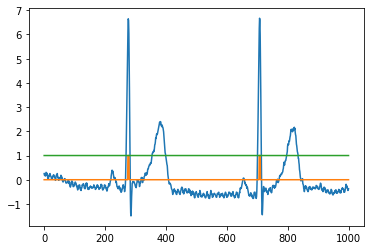

In [42]:
i = 1
plt.plot(all_x[i,:,:])
plt.plot(yy_predicted[i,:,:])